# Tworzenie i trening autoenkoderów

## Przygotowanie zbioru danych

In [19]:
%matplotlib inline

import zipfile
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [20]:
with zipfile.ZipFile("data/fashion-mnist.zip") as z:
    with z.open("fashion-mnist_train.csv") as f:
        train_df = pd.read_csv(f)

    with z.open("fashion-mnist_test.csv") as f:
        test_df = pd.read_csv(f)

train = train_df.drop('label', axis='columns').to_numpy() / 255.0
test = test_df.drop('label', axis='columns').to_numpy() / 255.0

## Architektura autoenkoderów

In [26]:
import numpy as np
from keras.layers import Input, Dense, Lambda, Conv2D, MaxPooling2D, UpSampling2D, Reshape
from keras.models import Model, model_from_json
from keras import backend as K
from keras import objectives

In [42]:
def sampling(previous_layers, batch_size, dest_dim):
    z_mean, z_variance = previous_layers
    epsilon = K.random_normal(shape=(batch_size, dest_dim))
    
    return z_mean + K.exp(z_variance) * epsilon

def vae_loss(x, x_decoded_mean):
    xent_loss = objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_variance - K.square(z_mean) - K.exp(z_variance), axis=-1)
    return xent_loss + kl_loss

def prepare_models(input_layer, reduced, decoded):
    end_to_end = Model(input_layer, decoded)
    encoder = Model(input_layer, reduced)
    
    return end_to_end, encoder

In [136]:
def load_model(model_name):
    with open(f'autoencoders/models/{model_name}.json') as file:
        loaded_json = file.read()
    return model_from_json(loaded_json)

def load_weights(model, model_name, epochs):
    model.load_weights(f'autoencoders/weights/{model_name}_e{epochs}.h5')

def save_model(model, filename):
    model_json = model.to_json()
    with open(f'autoencoders/models/{filename}.json', 'w') as file:
        file.write(model_json)
    
def save_weights(model, filename):
    model.save_weights(f'autoencoders/weights/{filename}.h5')

### Autoenkoder wariacyjny z 2 warstwami ukrytymi

In [124]:
def get_2hl_intermediate_dims(initial_dim, dest_dim):
    intermediate_dim_1 = int((initial_dim + dest_dim) / 2)
    
    return intermediate_dim_1

def create_2hl_architecture(batch_size, initial_dim, intermediate_dim_1, dest_dim):
    input_layer = Input(batch_shape=(batch_size, initial_dim))

    encoder_l1 = Dense(intermediate_dim_1, activation='relu')(input_layer)

    z_mean = Dense(dest_dim, name='z_mean')(encoder_l1)
    z_variance = Dense(dest_dim, name='z_variance')(encoder_l1)

    reduced = Lambda(sampling, arguments={'batch_size': batch_size, 'dest_dim': dest_dim})([z_mean, z_variance])

    decoder_l1 = Dense(intermediate_dim_1, activation='relu')(reduced)

    decoded = Dense(initial_dim, activation='sigmoid')(decoder_l1)
    
    return input_layer, reduced, decoded, z_mean, z_variance

In [59]:
def create_2hl_model(batch_size, initial_dim, dest_dim):
    intermediate_dim_1 = get_2hl_intermediate_dims(initial_dim, dest_dim)
    input_layer, reduced, decoded, z_mean, z_variance = create_2hl_architecture(batch_size,
                                                                            initial_dim,
                                                                            intermediate_dim_1,
                                                                            dest_dim
                                                                           )
    end_to_end, encoder = prepare_models(input_layer, reduced, decoded)
    return end_to_end, encoder, z_mean, z_variance

### Autoenkoder wariacyjny z 4 warstwami ukrytymi

In [125]:
def get_4hl_intermediate_dims(initial_dim, dest_dim):
    intermediate_dim_1 = int((initial_dim + dest_dim) / 2)
    intermediate_dim_2 = int((intermediate_dim_1 + dest_dim) / 2)
    
    return intermediate_dim_1, intermediate_dim_2

def create_4hl_architecture(batch_size, initial_dim, intermediate_dim_1, intermediate_dim_2, dest_dim):
    input_layer = Input(batch_shape=(batch_size, initial_dim))

    encoder_l1 = Dense(intermediate_dim_1, activation='relu')(input_layer)
    encoder_l2 = Dense(intermediate_dim_2, activation='relu')(encoder_l1)

    z_mean = Dense(dest_dim, name='z_mean')(encoder_l2)
    z_variance = Dense(dest_dim, name='z_variance')(encoder_l2)

    reduced = Lambda(sampling, arguments={'batch_size': batch_size, 'dest_dim': dest_dim})([z_mean, z_variance])

    decoder_l1 = Dense(intermediate_dim_2, activation='relu')(reduced)
    decoder_l2 = Dense(intermediate_dim_1, activation='relu')(decoder_l1)

    decoded = Dense(initial_dim, activation='sigmoid')(decoder_l2)
    
    return input_layer, reduced, decoded, z_mean, z_variance

In [60]:
def create_4hl_model(batch_size, initial_dim, dest_dim):
    intermediate_dim_1, intermediate_dim_2 = get_4hl_intermediate_dims(initial_dim, dest_dim)
    input_layer, reduced, decoded, z_mean, z_variance = create_4hl_architecture(batch_size,
                                                                            initial_dim,
                                                                            intermediate_dim_1,
                                                                            intermediate_dim_2,
                                                                            dest_dim
                                                                           )
    end_to_end, encoder = prepare_models(input_layer, reduced, decoded)
    return end_to_end, encoder, z_mean, z_variance

### Autoenkoder konwolucyjno-wariacyjny

In [71]:
def get_cvae_intermediate_dims(initial_dim, dest_dim):
    intermediate_dim_1 = 16
    intermediate_dim_2 = 8
    intermediate_dim_3 = 150
    
    return intermediate_dim_1, intermediate_dim_2, intermediate_dim_3

def create_cvae_architecture(batch_size,
                        initial_dim,
                        intermediate_dim_1,
                        intermediate_dim_2,
                        intermediate_dim_3,
                        dest_dim):
    input_layer = Input(batch_shape=(batch_size, initial_dim))
    
    encoder_l0 = Reshape((28, 28, 1))(input_layer)
    encoder_l1 = Conv2D(intermediate_dim_1, (3, 3), padding='same', activation='relu', data_format='channels_last')(encoder_l0)
    encoder_l2 = MaxPooling2D((2, 2), padding='same')(encoder_l1)
    encoder_l3 = Conv2D(intermediate_dim_2, (3, 3), padding='same', activation='relu', data_format='channels_last')(encoder_l2)
    encoder_l4 = MaxPooling2D((2, 2), padding='same')(encoder_l3)
    encoder_l5 = Reshape((7*7*8,))(encoder_l4)
    encoder_l6 = Dense(intermediate_dim_3, activation='relu')(encoder_l5)

    z_mean = Dense(dest_dim, name='z_mean')(encoder_l6)
    z_variance = Dense(dest_dim, name='z_variance')(encoder_l6)

    reduced = Lambda(sampling, arguments={'batch_size': batch_size, 'dest_dim': dest_dim})([z_mean, z_variance])

    decoder_l1 = Dense(intermediate_dim_3, activation='relu')(reduced)
    decoder_l2 = Dense(7*7*8, activation='relu')(decoder_l1)
    decoder_l3 = Reshape((7, 7, 8))(decoder_l2)
    decoder_l4 = Conv2D(intermediate_dim_2, (3, 3), padding='same', activation='relu', data_format='channels_last')(decoder_l3)
    decoder_l5 = UpSampling2D((2,2))(decoder_l4)
    decoder_l6 = Conv2D(intermediate_dim_1, (3, 3), padding='same', activation='relu', data_format='channels_last')(decoder_l5)
    decoder_l7 = UpSampling2D((2,2))(decoder_l6)
    
    decoder_l8 = Conv2D(1, (3,3), activation='sigmoid', data_format='channels_last', padding='same')(decoder_l7)
    decoded = Reshape((initial_dim,))(decoder_l8)
    
    return input_layer, reduced, decoded, z_mean, z_variance

In [72]:
def create_cvae_model(batch_size, initial_dim, dest_dim):
    intermediate_dim_1, intermediate_dim_2, intermediate_dim_3 = get_cvae_intermediate_dims(initial_dim, dest_dim)
    input_layer, reduced, decoded, z_mean, z_variance = create_cvae_architecture(batch_size,
                                                                            initial_dim,
                                                                            intermediate_dim_1,
                                                                            intermediate_dim_2,
                                                                            intermediate_dim_3,
                                                                            dest_dim
                                                                           )
    end_to_end, encoder = prepare_models(input_layer, reduced, decoded)
    return end_to_end, encoder, z_mean, z_variance

## Tworzenie i persystencja modeli

In [126]:
# enkoder wariacyjny, 2 warstwy ukryte, wymiar warstwy środkowej 15

batch_size = 10000
initial_dim = 784
dest_dim = 15

end_to_end_2hl_d15, encoder_2hl_d15, z_mean, z_variance = create_2hl_model(batch_size, initial_dim, dest_dim)
end_to_end_2hl_d15.compile(optimizer='rmsprop', loss=vae_loss)

save_model(end_to_end_2hl_d15, 'end_to_end_2hl_d15')
save_model(encoder_2hl_d15, 'encoder_2hl_d15')

In [127]:
# enkoder wariacyjny, 2 warstwy ukryte, wymiar warstwy środkowej 50

batch_size = 10000
initial_dim = 784
dest_dim = 50

end_to_end_2hl_d50, encoder_2hl_d50, z_mean, z_variance = create_2hl_model(batch_size, initial_dim, dest_dim)
end_to_end_2hl_d50.compile(optimizer='rmsprop', loss=vae_loss)

save_model(end_to_end_2hl_d50, 'end_to_end_2hl_d50')
save_model(encoder_2hl_d50, 'encoder_2hl_d50')

In [128]:
# enkoder wariacyjny, 2 warstwy ukryte, wymiar warstwy środkowej 100

batch_size = 10000
initial_dim = 784
dest_dim = 100

end_to_end_2hl_d100, encoder_2hl_d100, z_mean, z_variance = create_2hl_model(batch_size, initial_dim, dest_dim)
end_to_end_2hl_d100.compile(optimizer='rmsprop', loss=vae_loss)

save_model(end_to_end_2hl_d100, 'end_to_end_2hl_d100')
save_model(encoder_2hl_d100, 'encoder_2hl_d100')

In [129]:
# enkoder wariacyjny, 4 warstwy ukryte, wymiar warstwy środkowej 15

batch_size = 10000
initial_dim = 784
dest_dim = 15

end_to_end_4hl_d15, encoder_4hl_d15, z_mean, z_variance = create_4hl_model(batch_size, initial_dim, dest_dim)
end_to_end_4hl_d15.compile(optimizer='rmsprop', loss=vae_loss)

save_model(end_to_end_4hl_d15, 'end_to_end_4hl_d15')
save_model(encoder_4hl_d15, 'encoder_4hl_d15')

In [130]:
# enkoder wariacyjny, 4 warstwy ukryte, wymiar warstwy środkowej 50

batch_size = 10000
initial_dim = 784
dest_dim = 50

end_to_end_4hl_d50, encoder_4hl_d50, z_mean, z_variance = create_4hl_model(batch_size, initial_dim, dest_dim)
end_to_end_4hl_d50.compile(optimizer='rmsprop', loss=vae_loss)

save_model(end_to_end_4hl_d50, 'end_to_end_4hl_d50')
save_model(encoder_4hl_d50, 'encoder_4hl_d50')

In [131]:
# enkoder wariacyjny, 4 warstwy ukryte, wymiar warstwy środkowej 100

batch_size = 10000
initial_dim = 784
dest_dim = 100

end_to_end_4hl_d100, encoder_4hl_d100, z_mean, z_variance = create_4hl_model(batch_size, initial_dim, dest_dim)
end_to_end_4hl_d100.compile(optimizer='rmsprop', loss=vae_loss)

save_model(end_to_end_4hl_d100, 'end_to_end_4hl_d100')
save_model(encoder_4hl_d100, 'encoder_4hl_d100')

In [111]:
# enkoder konwolucyjno-wariacyjny, wymiar warstwy środkowej 15

batch_size = 10000
initial_dim = 784
dest_dim = 15

end_to_end_cvae_d15, encoder_cvae_d15, z_mean, z_variance = create_cvae_model(batch_size, initial_dim, dest_dim)
end_to_end_cvae_d15.compile(optimizer='rmsprop', loss=vae_loss)

save_model(end_to_end_cvae_d15, 'end_to_end_cvae_d15')
save_model(encoder_cvae_d15, 'encoder_cvae_d15')

In [112]:
# enkoder konwolucyjno-wariacyjny, wymiar warstwy środkowej 15

batch_size = 10000
initial_dim = 784
dest_dim = 50

end_to_end_cvae_d50, encoder_cvae_d50, z_mean, z_variance = create_cvae_model(batch_size, initial_dim, dest_dim)
end_to_end_cvae_d50.compile(optimizer='rmsprop', loss=vae_loss)

save_model(end_to_end_cvae_d50, 'end_to_end_cvae_d50')
save_model(encoder_cvae_d50, 'encoder_cvae_d50')

In [113]:
# enkoder konwolucyjno-wariacyjny, wymiar warstwy środkowej 15

batch_size = 10000
initial_dim = 784
dest_dim = 100

end_to_end_cvae_d100, encoder_cvae_d100, z_mean, z_variance = create_cvae_model(batch_size, initial_dim, dest_dim)
end_to_end_cvae_d100.compile(optimizer='rmsprop', loss=vae_loss)

save_model(encoder_cvae_d100, 'encoder_cvae_d100')

## Trening modeli i persystencja wyuczonych wag

In [78]:
batch_size = 10000

In [101]:
epochs = 100

end_to_end_2hl_d15.fit(train, train,
                       shuffle=True,
                       epochs=epochs,
                       batch_size=batch_size,
                       validation_data=(test, test)
                      )

save_weights(end_to_end_2hl_d15, 'end_to_end_2hl_d15_e400')
save_weights(encoder_2hl_d15, 'encoder_2hl_d15_e400')

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 6s 93us/step - loss: 0.4438 - val_loss: 0.4434
Epoch 2/100
60000/60000 [==============================] - 6s 98us/step - loss: 0.4439 - val_loss: 0.4432
Epoch 3/100
60000/60000 [==============================] - 6s 94us/step - loss: 0.4439 - val_loss: 0.4437
Epoch 4/100
60000/60000 [==============================] - 6s 96us/step - loss: 0.4440 - val_loss: 0.4427
Epoch 5/100
60000/60000 [==============================] - 6s 106us/step - loss: 0.4443 - val_loss: 0.4438
Epoch 6/100
60000/60000 [==============================] - 6s 105us/step - loss: 0.4437 - val_loss: 0.4444
Epoch 7/100
60000/60000 [==============================] - 6s 101us/step - loss: 0.4444 - val_loss: 0.4425
Epoch 8/100
60000/60000 [==============================] - 5s 91us/step - loss: 0.4433 - val_loss: 0.4423
Epoch 9/100
60000/60000 [==============================] - 5s 91us/step - loss: 0.4447 - val_loss: 

60000/60000 [==============================] - 6s 104us/step - loss: 0.4425 - val_loss: 0.4413
Epoch 78/100
60000/60000 [==============================] - 6s 92us/step - loss: 0.4426 - val_loss: 0.4415
Epoch 79/100
60000/60000 [==============================] - 6s 92us/step - loss: 0.4425 - val_loss: 0.4416
Epoch 80/100
60000/60000 [==============================] - 6s 94us/step - loss: 0.4426 - val_loss: 0.4413
Epoch 81/100
60000/60000 [==============================] - 6s 98us/step - loss: 0.4426 - val_loss: 0.4408
Epoch 82/100
60000/60000 [==============================] - 6s 100us/step - loss: 0.4424 - val_loss: 0.4430
Epoch 83/100
60000/60000 [==============================] - 6s 98us/step - loss: 0.4428 - val_loss: 0.4409
Epoch 84/100
60000/60000 [==============================] - 6s 96us/step - loss: 0.4420 - val_loss: 0.4410
Epoch 85/100
60000/60000 [==============================] - 6s 97us/step - loss: 0.4420 - val_loss: 0.4409
Epoch 86/100
60000/60000 [======================

In [99]:
epochs = 400

end_to_end_2hl_d50.fit(train, train,
                       shuffle=True,
                       epochs=epochs,
                       batch_size=batch_size,
                       validation_data=(test, test)
                      )

save_weights(end_to_end_2hl_d50, 'end_to_end_2hl_d50_e400')
save_weights(encoder_2hl_d50, 'encoder_2hl_d50_e400')

Train on 60000 samples, validate on 10000 samples
Epoch 1/400
60000/60000 [==============================] - 8s 127us/step - loss: 0.7514 - val_loss: 0.5832
Epoch 2/400
60000/60000 [==============================] - 6s 100us/step - loss: 0.5625 - val_loss: 0.5397
Epoch 3/400
60000/60000 [==============================] - 6s 97us/step - loss: 0.5298 - val_loss: 0.5185
Epoch 4/400
60000/60000 [==============================] - 6s 97us/step - loss: 0.5135 - val_loss: 0.5072
Epoch 5/400
60000/60000 [==============================] - 6s 96us/step - loss: 0.5045 - val_loss: 0.5005
Epoch 6/400
60000/60000 [==============================] - 6s 97us/step - loss: 0.4987 - val_loss: 0.4953
Epoch 7/400
60000/60000 [==============================] - 6s 97us/step - loss: 0.4931 - val_loss: 0.4883
Epoch 8/400
60000/60000 [==============================] - 6s 97us/step - loss: 0.4856 - val_loss: 0.4836
Epoch 9/400
60000/60000 [==============================] - 6s 98us/step - loss: 0.4772 - val_loss: 0

60000/60000 [==============================] - 6s 95us/step - loss: 0.4013 - val_loss: 0.4022
Epoch 78/400
60000/60000 [==============================] - 6s 96us/step - loss: 0.4008 - val_loss: 0.3973
Epoch 79/400
60000/60000 [==============================] - 6s 96us/step - loss: 0.3984 - val_loss: 0.3971
Epoch 80/400
60000/60000 [==============================] - 6s 96us/step - loss: 0.3986 - val_loss: 0.3965
Epoch 81/400
60000/60000 [==============================] - 6s 96us/step - loss: 0.3974 - val_loss: 0.3965
Epoch 82/400
60000/60000 [==============================] - 6s 96us/step - loss: 0.3983 - val_loss: 0.3988
Epoch 83/400
60000/60000 [==============================] - 6s 96us/step - loss: 0.3987 - val_loss: 0.4007
Epoch 84/400
60000/60000 [==============================] - 6s 96us/step - loss: 0.3967 - val_loss: 0.3961
Epoch 85/400
60000/60000 [==============================] - 6s 97us/step - loss: 0.3955 - val_loss: 0.3949
Epoch 86/400
60000/60000 [========================

60000/60000 [==============================] - 6s 96us/step - loss: 0.3833 - val_loss: 0.3818
Epoch 154/400
60000/60000 [==============================] - 6s 96us/step - loss: 0.3880 - val_loss: 0.3822
Epoch 155/400
60000/60000 [==============================] - 6s 96us/step - loss: 0.3835 - val_loss: 0.3818
Epoch 156/400
60000/60000 [==============================] - 6s 96us/step - loss: 0.3821 - val_loss: 0.3824
Epoch 157/400
60000/60000 [==============================] - 6s 98us/step - loss: 0.3840 - val_loss: 0.3830
Epoch 158/400
60000/60000 [==============================] - 6s 96us/step - loss: 0.3825 - val_loss: 0.3828
Epoch 159/400
60000/60000 [==============================] - 6s 97us/step - loss: 0.3845 - val_loss: 0.3817
Epoch 160/400
60000/60000 [==============================] - 6s 96us/step - loss: 0.3845 - val_loss: 0.3822
Epoch 161/400
60000/60000 [==============================] - 6s 96us/step - loss: 0.3823 - val_loss: 0.3819
Epoch 162/400
60000/60000 [===============

Epoch 229/400
60000/60000 [==============================] - 6s 96us/step - loss: 0.3797 - val_loss: 0.3791
Epoch 230/400
60000/60000 [==============================] - 6s 97us/step - loss: 0.3788 - val_loss: 0.3784
Epoch 231/400
60000/60000 [==============================] - 6s 96us/step - loss: 0.3805 - val_loss: 0.3776
Epoch 232/400
60000/60000 [==============================] - 6s 97us/step - loss: 0.3785 - val_loss: 0.3790
Epoch 233/400
60000/60000 [==============================] - 6s 96us/step - loss: 0.3782 - val_loss: 0.3780
Epoch 234/400
60000/60000 [==============================] - 6s 96us/step - loss: 0.3793 - val_loss: 0.3793
Epoch 235/400
60000/60000 [==============================] - 6s 96us/step - loss: 0.3788 - val_loss: 0.3782
Epoch 236/400
60000/60000 [==============================] - 6s 96us/step - loss: 0.3800 - val_loss: 0.3770
Epoch 237/400
60000/60000 [==============================] - 6s 96us/step - loss: 0.3775 - val_loss: 0.3769
Epoch 238/400
60000/60000 [=

Epoch 305/400
60000/60000 [==============================] - 6s 96us/step - loss: 0.3768 - val_loss: 0.3764
Epoch 306/400
60000/60000 [==============================] - 6s 97us/step - loss: 0.3773 - val_loss: 0.3761
Epoch 307/400
60000/60000 [==============================] - 6s 96us/step - loss: 0.3763 - val_loss: 0.3761
Epoch 308/400
60000/60000 [==============================] - 6s 96us/step - loss: 0.3762 - val_loss: 0.3768
Epoch 309/400
60000/60000 [==============================] - 6s 96us/step - loss: 0.3776 - val_loss: 0.3760
Epoch 310/400
60000/60000 [==============================] - 6s 96us/step - loss: 0.3759 - val_loss: 0.3777
Epoch 311/400
60000/60000 [==============================] - 6s 96us/step - loss: 0.3773 - val_loss: 0.3772
Epoch 312/400
60000/60000 [==============================] - 6s 98us/step - loss: 0.3758 - val_loss: 0.3762
Epoch 313/400
60000/60000 [==============================] - 6s 105us/step - loss: 0.3773 - val_loss: 0.3774
Epoch 314/400
60000/60000 [

Epoch 381/400
60000/60000 [==============================] - 6s 96us/step - loss: 0.3751 - val_loss: 0.3751
Epoch 382/400
60000/60000 [==============================] - 6s 96us/step - loss: 0.3754 - val_loss: 0.3735
Epoch 383/400
60000/60000 [==============================] - 6s 97us/step - loss: 0.3744 - val_loss: 0.3761
Epoch 384/400
60000/60000 [==============================] - 6s 96us/step - loss: 0.3754 - val_loss: 0.3747
Epoch 385/400
60000/60000 [==============================] - 6s 95us/step - loss: 0.3756 - val_loss: 0.3747
Epoch 386/400
60000/60000 [==============================] - 6s 96us/step - loss: 0.3751 - val_loss: 0.3739
Epoch 387/400
60000/60000 [==============================] - 6s 96us/step - loss: 0.3759 - val_loss: 0.3739
Epoch 388/400
60000/60000 [==============================] - 6s 96us/step - loss: 0.3741 - val_loss: 0.3750
Epoch 389/400
60000/60000 [==============================] - 6s 97us/step - loss: 0.3754 - val_loss: 0.3739
Epoch 390/400
60000/60000 [=

In [100]:
epochs = 400

end_to_end_2hl_d100.fit(train, train,
                       shuffle=True,
                       epochs=epochs,
                       batch_size=batch_size,
                       validation_data=(test, test)
                      )

save_weights(end_to_end_2hl_d100, 'end_to_end_2hl_d100_e400')
save_weights(encoder_2hl_d100, 'encoder_2hl_d100_e400')

Train on 60000 samples, validate on 10000 samples
Epoch 1/400
60000/60000 [==============================] - 8s 140us/step - loss: 0.7219 - val_loss: 0.5669
Epoch 2/400
60000/60000 [==============================] - 6s 104us/step - loss: 0.5477 - val_loss: 0.5281
Epoch 3/400
60000/60000 [==============================] - 6s 102us/step - loss: 0.5200 - val_loss: 0.5104
Epoch 4/400
60000/60000 [==============================] - 6s 103us/step - loss: 0.5051 - val_loss: 0.4961
Epoch 5/400
60000/60000 [==============================] - 6s 103us/step - loss: 0.4901 - val_loss: 0.4797
Epoch 6/400
60000/60000 [==============================] - 6s 103us/step - loss: 0.4786 - val_loss: 0.4654
Epoch 7/400
60000/60000 [==============================] - 6s 102us/step - loss: 0.4660 - val_loss: 0.4562
Epoch 8/400
60000/60000 [==============================] - 6s 102us/step - loss: 0.4581 - val_loss: 0.4505
Epoch 9/400
60000/60000 [==============================] - 6s 102us/step - loss: 0.4580 - val_

60000/60000 [==============================] - 6s 103us/step - loss: 0.3863 - val_loss: 0.3831
Epoch 77/400
60000/60000 [==============================] - 6s 102us/step - loss: 0.3863 - val_loss: 0.3844
Epoch 78/400
60000/60000 [==============================] - 6s 102us/step - loss: 0.3850 - val_loss: 0.3860
Epoch 79/400
60000/60000 [==============================] - 6s 101us/step - loss: 0.3847 - val_loss: 0.3846
Epoch 80/400
60000/60000 [==============================] - 6s 102us/step - loss: 0.3850 - val_loss: 0.3816
Epoch 81/400
60000/60000 [==============================] - 6s 102us/step - loss: 0.3840 - val_loss: 0.3823
Epoch 82/400
60000/60000 [==============================] - 6s 101us/step - loss: 0.3838 - val_loss: 0.3838
Epoch 83/400
60000/60000 [==============================] - 6s 103us/step - loss: 0.3828 - val_loss: 0.3843
Epoch 84/400
60000/60000 [==============================] - 6s 101us/step - loss: 0.3830 - val_loss: 0.3818
Epoch 85/400
60000/60000 [===============

60000/60000 [==============================] - 6s 103us/step - loss: 0.3648 - val_loss: 0.3618
Epoch 152/400
60000/60000 [==============================] - 6s 104us/step - loss: 0.3633 - val_loss: 0.3629
Epoch 153/400
60000/60000 [==============================] - 6s 105us/step - loss: 0.3675 - val_loss: 0.3644
Epoch 154/400
60000/60000 [==============================] - 6s 105us/step - loss: 0.3643 - val_loss: 0.3623
Epoch 155/400
60000/60000 [==============================] - 6s 103us/step - loss: 0.3649 - val_loss: 0.3636
Epoch 156/400
60000/60000 [==============================] - 6s 104us/step - loss: 0.3636 - val_loss: 0.3694
Epoch 157/400
60000/60000 [==============================] - 6s 101us/step - loss: 0.3642 - val_loss: 0.3629
Epoch 158/400
60000/60000 [==============================] - 6s 102us/step - loss: 0.3659 - val_loss: 0.3647
Epoch 159/400
60000/60000 [==============================] - 6s 102us/step - loss: 0.3636 - val_loss: 0.3631
Epoch 160/400
60000/60000 [======

60000/60000 [==============================] - 6s 103us/step - loss: 0.3595 - val_loss: 0.3577
Epoch 227/400
60000/60000 [==============================] - 7s 110us/step - loss: 0.3578 - val_loss: 0.3588
Epoch 228/400
60000/60000 [==============================] - 7s 110us/step - loss: 0.3581 - val_loss: 0.3588
Epoch 229/400
60000/60000 [==============================] - 6s 106us/step - loss: 0.3583 - val_loss: 0.3551
Epoch 230/400
60000/60000 [==============================] - 6s 104us/step - loss: 0.3593 - val_loss: 0.3572
Epoch 231/400
60000/60000 [==============================] - 6s 105us/step - loss: 0.3575 - val_loss: 0.3571
Epoch 232/400
60000/60000 [==============================] - 7s 110us/step - loss: 0.3573 - val_loss: 0.3585
Epoch 233/400
60000/60000 [==============================] - 7s 110us/step - loss: 0.3589 - val_loss: 0.3574
Epoch 234/400
60000/60000 [==============================] - 6s 106us/step - loss: 0.3574 - val_loss: 0.3568
Epoch 235/400
60000/60000 [======

60000/60000 [==============================] - 6s 105us/step - loss: 0.3539 - val_loss: 0.3550
Epoch 302/400
60000/60000 [==============================] - 6s 106us/step - loss: 0.3546 - val_loss: 0.3537
Epoch 303/400
60000/60000 [==============================] - 6s 103us/step - loss: 0.3536 - val_loss: 0.3550
Epoch 304/400
60000/60000 [==============================] - 6s 107us/step - loss: 0.3555 - val_loss: 0.3546
Epoch 305/400
60000/60000 [==============================] - 6s 102us/step - loss: 0.3539 - val_loss: 0.3536
Epoch 306/400
60000/60000 [==============================] - 6s 103us/step - loss: 0.3532 - val_loss: 0.3534
Epoch 307/400
60000/60000 [==============================] - 6s 102us/step - loss: 0.3554 - val_loss: 0.3535
Epoch 308/400
60000/60000 [==============================] - 6s 103us/step - loss: 0.3537 - val_loss: 0.3526
Epoch 309/400
60000/60000 [==============================] - 6s 105us/step - loss: 0.3535 - val_loss: 0.3534
Epoch 310/400
60000/60000 [======

60000/60000 [==============================] - 6s 103us/step - loss: 0.3518 - val_loss: 0.3516
Epoch 377/400
60000/60000 [==============================] - 6s 102us/step - loss: 0.3523 - val_loss: 0.3525
Epoch 378/400
60000/60000 [==============================] - 7s 114us/step - loss: 0.3516 - val_loss: 0.3504
Epoch 379/400
60000/60000 [==============================] - 8s 125us/step - loss: 0.3513 - val_loss: 0.3511
Epoch 380/400
60000/60000 [==============================] - 9s 145us/step - loss: 0.3527 - val_loss: 0.3529
Epoch 381/400
60000/60000 [==============================] - 8s 135us/step - loss: 0.3513 - val_loss: 0.3503
Epoch 382/400
60000/60000 [==============================] - 6s 108us/step - loss: 0.3510 - val_loss: 0.3505
Epoch 383/400
60000/60000 [==============================] - 6s 105us/step - loss: 0.3524 - val_loss: 0.3505
Epoch 384/400
60000/60000 [==============================] - 7s 109us/step - loss: 0.3530 - val_loss: 0.3512
Epoch 385/400
60000/60000 [======

In [104]:
epochs = 400

end_to_end_4hl_d15.fit(train, train,
                       shuffle=True,
                       epochs=epochs,
                       batch_size=batch_size,
                       validation_data=(test, test)
                      )

save_weights(end_to_end_4hl_d15, 'end_to_end_4hl_d15_e400')
save_weights(encoder_4hl_d15, 'encoder_4hl_d15_e400')

Train on 60000 samples, validate on 10000 samples
Epoch 1/400
60000/60000 [==============================] - 8s 133us/step - loss: 0.8019 - val_loss: 0.5425
Epoch 2/400
60000/60000 [==============================] - 6s 103us/step - loss: 0.5164 - val_loss: 0.5024
Epoch 3/400
60000/60000 [==============================] - 6s 99us/step - loss: 0.5001 - val_loss: 0.4981
Epoch 4/400
60000/60000 [==============================] - 6s 101us/step - loss: 0.4970 - val_loss: 0.4971
Epoch 5/400
60000/60000 [==============================] - 6s 99us/step - loss: 0.4956 - val_loss: 0.4943
Epoch 6/400
60000/60000 [==============================] - 6s 99us/step - loss: 0.4939 - val_loss: 0.4941
Epoch 7/400
60000/60000 [==============================] - 6s 101us/step - loss: 0.4949 - val_loss: 0.4979
Epoch 8/400
60000/60000 [==============================] - 6s 102us/step - loss: 0.4931 - val_loss: 0.4913
Epoch 9/400
60000/60000 [==============================] - 6s 100us/step - loss: 0.4927 - val_los

Epoch 77/400
60000/60000 [==============================] - 6s 100us/step - loss: 0.4562 - val_loss: 0.4567
Epoch 78/400
60000/60000 [==============================] - 6s 99us/step - loss: 0.4571 - val_loss: 0.4564
Epoch 79/400
60000/60000 [==============================] - 6s 99us/step - loss: 0.4562 - val_loss: 0.4546
Epoch 80/400
60000/60000 [==============================] - 6s 99us/step - loss: 0.4551 - val_loss: 0.4645
Epoch 81/400
60000/60000 [==============================] - 6s 100us/step - loss: 0.4587 - val_loss: 0.4558
Epoch 82/400
60000/60000 [==============================] - 6s 99us/step - loss: 0.4552 - val_loss: 0.4543
Epoch 83/400
60000/60000 [==============================] - 6s 100us/step - loss: 0.4546 - val_loss: 0.4535
Epoch 84/400
60000/60000 [==============================] - 6s 101us/step - loss: 0.4535 - val_loss: 0.4535
Epoch 85/400
60000/60000 [==============================] - 6s 100us/step - loss: 0.4534 - val_loss: 0.4526
Epoch 86/400
60000/60000 [======

Epoch 153/400
60000/60000 [==============================] - 6s 100us/step - loss: 0.4466 - val_loss: 0.4469
Epoch 154/400
60000/60000 [==============================] - 6s 99us/step - loss: 0.4477 - val_loss: 0.4444
Epoch 155/400
60000/60000 [==============================] - 6s 99us/step - loss: 0.4466 - val_loss: 0.4481
Epoch 156/400
60000/60000 [==============================] - 6s 99us/step - loss: 0.4461 - val_loss: 0.4455
Epoch 157/400
60000/60000 [==============================] - 6s 98us/step - loss: 0.4463 - val_loss: 0.4452
Epoch 158/400
60000/60000 [==============================] - 6s 99us/step - loss: 0.4464 - val_loss: 0.4462
Epoch 159/400
60000/60000 [==============================] - 6s 99us/step - loss: 0.4460 - val_loss: 0.4444
Epoch 160/400
60000/60000 [==============================] - 6s 99us/step - loss: 0.4464 - val_loss: 0.4498
Epoch 161/400
60000/60000 [==============================] - 6s 99us/step - loss: 0.4471 - val_loss: 0.4438
Epoch 162/400
60000/60000 [

60000/60000 [==============================] - 6s 98us/step - loss: 0.4444 - val_loss: 0.4465
Epoch 229/400
60000/60000 [==============================] - 6s 99us/step - loss: 0.4442 - val_loss: 0.4416
Epoch 230/400
60000/60000 [==============================] - 6s 99us/step - loss: 0.4425 - val_loss: 0.4428
Epoch 231/400
60000/60000 [==============================] - 6s 99us/step - loss: 0.4442 - val_loss: 0.4440
Epoch 232/400
60000/60000 [==============================] - 6s 99us/step - loss: 0.4441 - val_loss: 0.4421
Epoch 233/400
60000/60000 [==============================] - 6s 99us/step - loss: 0.4432 - val_loss: 0.4438
Epoch 234/400
60000/60000 [==============================] - 6s 100us/step - loss: 0.4439 - val_loss: 0.4428
Epoch 235/400
60000/60000 [==============================] - 6s 101us/step - loss: 0.4427 - val_loss: 0.4420
Epoch 236/400
60000/60000 [==============================] - 6s 100us/step - loss: 0.4430 - val_loss: 0.4421
Epoch 237/400
60000/60000 [============

60000/60000 [==============================] - 6s 100us/step - loss: 0.4404 - val_loss: 0.4417
Epoch 304/400
60000/60000 [==============================] - 6s 107us/step - loss: 0.4419 - val_loss: 0.4413
Epoch 305/400
60000/60000 [==============================] - 6s 101us/step - loss: 0.4415 - val_loss: 0.4397
Epoch 306/400
60000/60000 [==============================] - 6s 99us/step - loss: 0.4403 - val_loss: 0.4405
Epoch 307/400
60000/60000 [==============================] - 6s 99us/step - loss: 0.4412 - val_loss: 0.4399
Epoch 308/400
60000/60000 [==============================] - 6s 99us/step - loss: 0.4415 - val_loss: 0.4451
Epoch 309/400
60000/60000 [==============================] - 6s 99us/step - loss: 0.4422 - val_loss: 0.4396
Epoch 310/400
60000/60000 [==============================] - 6s 100us/step - loss: 0.4408 - val_loss: 0.4404
Epoch 311/400
60000/60000 [==============================] - 6s 99us/step - loss: 0.4407 - val_loss: 0.4420
Epoch 312/400
60000/60000 [===========

Epoch 379/400
60000/60000 [==============================] - 6s 99us/step - loss: 0.4389 - val_loss: 0.4377
Epoch 380/400
60000/60000 [==============================] - 6s 99us/step - loss: 0.4394 - val_loss: 0.4409
Epoch 381/400
60000/60000 [==============================] - 6s 99us/step - loss: 0.4398 - val_loss: 0.4387
Epoch 382/400
60000/60000 [==============================] - 6s 99us/step - loss: 0.4387 - val_loss: 0.4381
Epoch 383/400
60000/60000 [==============================] - 6s 99us/step - loss: 0.4386 - val_loss: 0.4384
Epoch 384/400
60000/60000 [==============================] - 6s 99us/step - loss: 0.4393 - val_loss: 0.4414
Epoch 385/400
60000/60000 [==============================] - 6s 99us/step - loss: 0.4396 - val_loss: 0.4375
Epoch 386/400
60000/60000 [==============================] - 6s 100us/step - loss: 0.4387 - val_loss: 0.4389
Epoch 387/400
60000/60000 [==============================] - 6s 99us/step - loss: 0.4389 - val_loss: 0.4385
Epoch 388/400
60000/60000 [

In [132]:
epochs = 400

end_to_end_4hl_d50.fit(train, train,
                       shuffle=True,
                       epochs=epochs,
                       batch_size=batch_size,
                       validation_data=(test, test)
                      )

save_weights(end_to_end_4hl_d50, 'end_to_end_4hl_d50_e400')
save_weights(encoder_4hl_d50, 'encoder_4hl_d50_e400')

Train on 60000 samples, validate on 10000 samples
Epoch 1/400
60000/60000 [==============================] - 8s 139us/step - loss: 0.6734 - val_loss: 0.5104
Epoch 2/400
60000/60000 [==============================] - 6s 107us/step - loss: 0.5039 - val_loss: 0.4975
Epoch 3/400
60000/60000 [==============================] - 7s 110us/step - loss: 0.4972 - val_loss: 0.4959
Epoch 4/400
60000/60000 [==============================] - 6s 107us/step - loss: 0.4965 - val_loss: 0.4938
Epoch 5/400
60000/60000 [==============================] - 6s 107us/step - loss: 0.4939 - val_loss: 0.4957
Epoch 6/400
60000/60000 [==============================] - 6s 106us/step - loss: 0.4943 - val_loss: 0.4922
Epoch 7/400
60000/60000 [==============================] - 6s 107us/step - loss: 0.4929 - val_loss: 0.4914
Epoch 8/400
60000/60000 [==============================] - 6s 108us/step - loss: 0.4929 - val_loss: 0.4916
Epoch 9/400
60000/60000 [==============================] - 6s 106us/step - loss: 0.4916 - val_

60000/60000 [==============================] - 7s 115us/step - loss: 0.3971 - val_loss: 0.3967
Epoch 77/400
60000/60000 [==============================] - 7s 109us/step - loss: 0.4000 - val_loss: 0.4025
Epoch 78/400
60000/60000 [==============================] - 6s 107us/step - loss: 0.3971 - val_loss: 0.3940
Epoch 79/400
60000/60000 [==============================] - 7s 110us/step - loss: 0.3993 - val_loss: 0.3955
Epoch 80/400
60000/60000 [==============================] - 7s 114us/step - loss: 0.3945 - val_loss: 0.3945
Epoch 81/400
60000/60000 [==============================] - 7s 108us/step - loss: 0.3991 - val_loss: 0.3949
Epoch 82/400
60000/60000 [==============================] - 7s 113us/step - loss: 0.3947 - val_loss: 0.3971
Epoch 83/400
60000/60000 [==============================] - 6s 108us/step - loss: 0.3962 - val_loss: 0.3925
Epoch 84/400
60000/60000 [==============================] - 7s 109us/step - loss: 0.3981 - val_loss: 0.3960
Epoch 85/400
60000/60000 [===============

60000/60000 [==============================] - 6s 107us/step - loss: 0.3842 - val_loss: 0.3822
Epoch 152/400
60000/60000 [==============================] - 7s 109us/step - loss: 0.3816 - val_loss: 0.3814
Epoch 153/400
60000/60000 [==============================] - 6s 108us/step - loss: 0.3821 - val_loss: 0.3818
Epoch 154/400
60000/60000 [==============================] - 7s 109us/step - loss: 0.3855 - val_loss: 0.3825
Epoch 155/400
60000/60000 [==============================] - 6s 107us/step - loss: 0.3820 - val_loss: 0.3793
Epoch 156/400
60000/60000 [==============================] - 7s 109us/step - loss: 0.3812 - val_loss: 0.3825
Epoch 157/400
60000/60000 [==============================] - 6s 108us/step - loss: 0.3827 - val_loss: 0.3856
Epoch 158/400
60000/60000 [==============================] - 6s 107us/step - loss: 0.3835 - val_loss: 0.3793
Epoch 159/400
60000/60000 [==============================] - 6s 108us/step - loss: 0.3825 - val_loss: 0.3810
Epoch 160/400
60000/60000 [======

60000/60000 [==============================] - 6s 108us/step - loss: 0.3793 - val_loss: 0.3799
Epoch 227/400
60000/60000 [==============================] - 7s 109us/step - loss: 0.3761 - val_loss: 0.3754
Epoch 228/400
60000/60000 [==============================] - 6s 107us/step - loss: 0.3759 - val_loss: 0.3744
Epoch 229/400
60000/60000 [==============================] - 6s 107us/step - loss: 0.3789 - val_loss: 0.3773
Epoch 230/400
60000/60000 [==============================] - 6s 108us/step - loss: 0.3769 - val_loss: 0.3747
Epoch 231/400
60000/60000 [==============================] - 6s 107us/step - loss: 0.3747 - val_loss: 0.3759
Epoch 232/400
60000/60000 [==============================] - 6s 106us/step - loss: 0.3792 - val_loss: 0.3772
Epoch 233/400
60000/60000 [==============================] - 6s 108us/step - loss: 0.3775 - val_loss: 0.3768
Epoch 234/400
60000/60000 [==============================] - 6s 107us/step - loss: 0.3762 - val_loss: 0.3752
Epoch 235/400
60000/60000 [======

60000/60000 [==============================] - 6s 108us/step - loss: 0.3758 - val_loss: 0.3708
Epoch 302/400
60000/60000 [==============================] - 6s 107us/step - loss: 0.3721 - val_loss: 0.3751
Epoch 303/400
60000/60000 [==============================] - 7s 109us/step - loss: 0.3748 - val_loss: 0.3726
Epoch 304/400
60000/60000 [==============================] - 7s 115us/step - loss: 0.3730 - val_loss: 0.3765
Epoch 305/400
60000/60000 [==============================] - 6s 108us/step - loss: 0.3754 - val_loss: 0.3710
Epoch 306/400
60000/60000 [==============================] - 7s 117us/step - loss: 0.3721 - val_loss: 0.3729
Epoch 307/400
60000/60000 [==============================] - 7s 117us/step - loss: 0.3747 - val_loss: 0.3716
Epoch 308/400
60000/60000 [==============================] - 7s 120us/step - loss: 0.3720 - val_loss: 0.3744
Epoch 309/400
60000/60000 [==============================] - 7s 115us/step - loss: 0.3766 - val_loss: 0.3715
Epoch 310/400
60000/60000 [======

60000/60000 [==============================] - 6s 107us/step - loss: 0.3710 - val_loss: 0.3708
Epoch 377/400
60000/60000 [==============================] - 7s 109us/step - loss: 0.3725 - val_loss: 0.3715
Epoch 378/400
60000/60000 [==============================] - 7s 115us/step - loss: 0.3710 - val_loss: 0.3698
Epoch 379/400
60000/60000 [==============================] - 6s 106us/step - loss: 0.3718 - val_loss: 0.3721
Epoch 380/400
60000/60000 [==============================] - 7s 121us/step - loss: 0.3714 - val_loss: 0.3716
Epoch 381/400
60000/60000 [==============================] - 7s 124us/step - loss: 0.3710 - val_loss: 0.3694
Epoch 382/400
60000/60000 [==============================] - 7s 114us/step - loss: 0.3727 - val_loss: 0.3697
Epoch 383/400
60000/60000 [==============================] - 7s 115us/step - loss: 0.3698 - val_loss: 0.3718
Epoch 384/400
60000/60000 [==============================] - 7s 120us/step - loss: 0.3737 - val_loss: 0.3698
Epoch 385/400
60000/60000 [======

In [133]:
epochs = 400

end_to_end_4hl_d100.fit(train, train,
                       shuffle=True,
                       epochs=epochs,
                       batch_size=batch_size,
                       validation_data=(test, test)
                      )

save_weights(end_to_end_4hl_d100, 'end_to_end_4hl_d100_e400')
save_weights(encoder_4hl_d100, 'encoder_4hl_d100_e400')

Train on 60000 samples, validate on 10000 samples
Epoch 1/400
60000/60000 [==============================] - 10s 161us/step - loss: 0.6243 - val_loss: 0.5072
Epoch 2/400
60000/60000 [==============================] - 7s 121us/step - loss: 0.5023 - val_loss: 0.4980
Epoch 3/400
60000/60000 [==============================] - 7s 120us/step - loss: 0.4976 - val_loss: 0.4968
Epoch 4/400
60000/60000 [==============================] - 7s 118us/step - loss: 0.4971 - val_loss: 0.4955
Epoch 5/400
60000/60000 [==============================] - 7s 115us/step - loss: 0.4948 - val_loss: 0.4952
Epoch 6/400
60000/60000 [==============================] - 7s 114us/step - loss: 0.4938 - val_loss: 0.4926
Epoch 7/400
60000/60000 [==============================] - 7s 118us/step - loss: 0.4919 - val_loss: 0.4907
Epoch 8/400
60000/60000 [==============================] - 7s 119us/step - loss: 0.4899 - val_loss: 0.4862
Epoch 9/400
60000/60000 [==============================] - 7s 118us/step - loss: 0.4862 - val

60000/60000 [==============================] - 7s 116us/step - loss: 0.3744 - val_loss: 0.3778
Epoch 77/400
60000/60000 [==============================] - 7s 124us/step - loss: 0.3788 - val_loss: 0.3756
Epoch 78/400
60000/60000 [==============================] - 7s 117us/step - loss: 0.3762 - val_loss: 0.3725
Epoch 79/400
60000/60000 [==============================] - 7s 118us/step - loss: 0.3780 - val_loss: 0.3770
Epoch 80/400
60000/60000 [==============================] - 7s 120us/step - loss: 0.3736 - val_loss: 0.3713
Epoch 81/400
60000/60000 [==============================] - 7s 122us/step - loss: 0.3716 - val_loss: 0.3813
Epoch 82/400
60000/60000 [==============================] - 7s 124us/step - loss: 0.3757 - val_loss: 0.3709
Epoch 83/400
60000/60000 [==============================] - 7s 114us/step - loss: 0.3740 - val_loss: 0.3778
Epoch 84/400
60000/60000 [==============================] - 7s 115us/step - loss: 0.3722 - val_loss: 0.3705
Epoch 85/400
60000/60000 [===============

60000/60000 [==============================] - 7s 121us/step - loss: 0.3555 - val_loss: 0.3520
Epoch 152/400
60000/60000 [==============================] - 7s 116us/step - loss: 0.3551 - val_loss: 0.3526
Epoch 153/400
60000/60000 [==============================] - 7s 117us/step - loss: 0.3573 - val_loss: 0.3578
Epoch 154/400
60000/60000 [==============================] - 7s 121us/step - loss: 0.3565 - val_loss: 0.3518
Epoch 155/400
60000/60000 [==============================] - 7s 125us/step - loss: 0.3521 - val_loss: 0.3545
Epoch 156/400
60000/60000 [==============================] - 7s 118us/step - loss: 0.3552 - val_loss: 0.3546
Epoch 157/400
60000/60000 [==============================] - 7s 122us/step - loss: 0.3588 - val_loss: 0.3572
Epoch 158/400
60000/60000 [==============================] - 7s 117us/step - loss: 0.3545 - val_loss: 0.3538
Epoch 159/400
60000/60000 [==============================] - 7s 118us/step - loss: 0.3540 - val_loss: 0.3518
Epoch 160/400
60000/60000 [======

60000/60000 [==============================] - 7s 119us/step - loss: 0.3486 - val_loss: 0.3500
Epoch 227/400
60000/60000 [==============================] - 7s 114us/step - loss: 0.3546 - val_loss: 0.3473
Epoch 228/400
60000/60000 [==============================] - 7s 115us/step - loss: 0.3473 - val_loss: 0.3481
Epoch 229/400
60000/60000 [==============================] - 7s 115us/step - loss: 0.3487 - val_loss: 0.3514
Epoch 230/400
60000/60000 [==============================] - 7s 122us/step - loss: 0.3518 - val_loss: 0.3486
Epoch 231/400
60000/60000 [==============================] - 7s 115us/step - loss: 0.3490 - val_loss: 0.3479
Epoch 232/400
60000/60000 [==============================] - 7s 119us/step - loss: 0.3483 - val_loss: 0.3475
Epoch 233/400
60000/60000 [==============================] - 7s 117us/step - loss: 0.3503 - val_loss: 0.3504
Epoch 234/400
60000/60000 [==============================] - 7s 117us/step - loss: 0.3511 - val_loss: 0.3460
Epoch 235/400
60000/60000 [======

60000/60000 [==============================] - 7s 112us/step - loss: 0.3471 - val_loss: 0.3480
Epoch 302/400
60000/60000 [==============================] - 7s 115us/step - loss: 0.3460 - val_loss: 0.3447
Epoch 303/400
60000/60000 [==============================] - 7s 116us/step - loss: 0.3462 - val_loss: 0.3440
Epoch 304/400
60000/60000 [==============================] - 7s 112us/step - loss: 0.3454 - val_loss: 0.3455
Epoch 305/400
60000/60000 [==============================] - 7s 114us/step - loss: 0.3488 - val_loss: 0.3444
Epoch 306/400
60000/60000 [==============================] - 7s 114us/step - loss: 0.3444 - val_loss: 0.3464
Epoch 307/400
60000/60000 [==============================] - 7s 120us/step - loss: 0.3456 - val_loss: 0.3439
Epoch 308/400
60000/60000 [==============================] - 7s 116us/step - loss: 0.3448 - val_loss: 0.3447
Epoch 309/400
60000/60000 [==============================] - 7s 114us/step - loss: 0.3459 - val_loss: 0.3503
Epoch 310/400
60000/60000 [======

60000/60000 [==============================] - 7s 118us/step - loss: 0.3436 - val_loss: 0.3431
Epoch 377/400
60000/60000 [==============================] - 7s 115us/step - loss: 0.3426 - val_loss: 0.3405
Epoch 378/400
60000/60000 [==============================] - 7s 123us/step - loss: 0.3428 - val_loss: 0.3454
Epoch 379/400
60000/60000 [==============================] - 8s 126us/step - loss: 0.3477 - val_loss: 0.3425
Epoch 380/400
60000/60000 [==============================] - 7s 123us/step - loss: 0.3420 - val_loss: 0.3410
Epoch 381/400
60000/60000 [==============================] - 7s 117us/step - loss: 0.3425 - val_loss: 0.3419
Epoch 382/400
60000/60000 [==============================] - 7s 121us/step - loss: 0.3454 - val_loss: 0.3456
Epoch 383/400
60000/60000 [==============================] - 8s 135us/step - loss: 0.3429 - val_loss: 0.3412
Epoch 384/400
60000/60000 [==============================] - 8s 128us/step - loss: 0.3436 - val_loss: 0.3414
Epoch 385/400
60000/60000 [======

In [ ]:
epochs = 300

end_to_end_cvae_d15.fit(train, train,
                       shuffle=True,
                       epochs=epochs,
                       batch_size=batch_size,
                       validation_data=(test, test)
                      )

save_weights(end_to_end_cvae_d15, 'end_to_end_cvae_d15_e300')
save_weights(encoder_cvae_d15, 'encoder_cvae_d15_e300')

In [134]:
epochs = 300

end_to_end_cvae_d50.fit(train, train,
                       shuffle=True,
                       epochs=epochs,
                       batch_size=batch_size,
                       validation_data=(test, test)
                      )

save_weights(end_to_end_cvae_d50, 'end_to_end_cvae_d50_e300')
save_weights(encoder_cvae_d50, 'encoder_cvae_d50_e300')

Train on 60000 samples, validate on 10000 samples
Epoch 1/300
60000/60000 [==============================] - 64s 1ms/step - loss: 0.6427 - val_loss: 0.5744
Epoch 2/300
60000/60000 [==============================] - 58s 970us/step - loss: 0.5493 - val_loss: 0.5265
Epoch 3/300
60000/60000 [==============================] - 56s 929us/step - loss: 0.5202 - val_loss: 0.5119
Epoch 4/300
60000/60000 [==============================] - 57s 953us/step - loss: 0.5088 - val_loss: 0.5066
Epoch 5/300
60000/60000 [==============================] - 60s 1ms/step - loss: 0.5034 - val_loss: 0.5014
Epoch 6/300
60000/60000 [==============================] - 57s 942us/step - loss: 0.4994 - val_loss: 0.4974
Epoch 7/300
60000/60000 [==============================] - 59s 979us/step - loss: 0.4946 - val_loss: 0.4922
Epoch 8/300
60000/60000 [==============================] - 54s 907us/step - loss: 0.4880 - val_loss: 0.4834
Epoch 9/300
60000/60000 [==============================] - 55s 921us/step - loss: 0.4799 -

Epoch 76/300
60000/60000 [==============================] - 54s 900us/step - loss: 0.4019 - val_loss: 0.4015
Epoch 77/300
60000/60000 [==============================] - 54s 893us/step - loss: 0.4010 - val_loss: 0.4035
Epoch 78/300
60000/60000 [==============================] - 53s 890us/step - loss: 0.4008 - val_loss: 0.3997
Epoch 79/300
60000/60000 [==============================] - 58s 967us/step - loss: 0.4000 - val_loss: 0.3994
Epoch 80/300
60000/60000 [==============================] - 55s 921us/step - loss: 0.4005 - val_loss: 0.3982
Epoch 81/300
60000/60000 [==============================] - 58s 961us/step - loss: 0.3987 - val_loss: 0.4003
Epoch 82/300
60000/60000 [==============================] - 56s 931us/step - loss: 0.3990 - val_loss: 0.3987
Epoch 83/300
60000/60000 [==============================] - 56s 940us/step - loss: 0.3988 - val_loss: 0.3966
Epoch 84/300
60000/60000 [==============================] - 57s 957us/step - loss: 0.3982 - val_loss: 0.3976
Epoch 85/300
60000/

60000/60000 [==============================] - 56s 936us/step - loss: 0.3867 - val_loss: 0.3888
Epoch 151/300
60000/60000 [==============================] - 56s 930us/step - loss: 0.3873 - val_loss: 0.3867
Epoch 152/300
60000/60000 [==============================] - 54s 906us/step - loss: 0.3868 - val_loss: 0.3864
Epoch 153/300
60000/60000 [==============================] - 53s 889us/step - loss: 0.3864 - val_loss: 0.3886
Epoch 154/300
60000/60000 [==============================] - 53s 890us/step - loss: 0.3869 - val_loss: 0.3845
Epoch 155/300
60000/60000 [==============================] - 54s 893us/step - loss: 0.3868 - val_loss: 0.3871
Epoch 156/300
60000/60000 [==============================] - 54s 894us/step - loss: 0.3856 - val_loss: 0.3865
Epoch 157/300
60000/60000 [==============================] - 54s 892us/step - loss: 0.3874 - val_loss: 0.3841
Epoch 158/300
60000/60000 [==============================] - 54s 895us/step - loss: 0.3859 - val_loss: 0.3856
Epoch 159/300
60000/6000

60000/60000 [==============================] - 56s 933us/step - loss: 0.3811 - val_loss: 0.3814
Epoch 225/300
60000/60000 [==============================] - 56s 940us/step - loss: 0.3810 - val_loss: 0.3804
Epoch 226/300
60000/60000 [==============================] - 57s 951us/step - loss: 0.3816 - val_loss: 0.3812
Epoch 227/300
60000/60000 [==============================] - 56s 937us/step - loss: 0.3809 - val_loss: 0.3802
Epoch 228/300
60000/60000 [==============================] - 56s 941us/step - loss: 0.3810 - val_loss: 0.3796
Epoch 229/300
60000/60000 [==============================] - 57s 942us/step - loss: 0.3809 - val_loss: 0.3819
Epoch 230/300
60000/60000 [==============================] - 56s 932us/step - loss: 0.3815 - val_loss: 0.3807
Epoch 231/300
60000/60000 [==============================] - 56s 926us/step - loss: 0.3804 - val_loss: 0.3800
Epoch 232/300
60000/60000 [==============================] - 57s 952us/step - loss: 0.3810 - val_loss: 0.3811
Epoch 233/300
60000/6000

60000/60000 [==============================] - 62s 1ms/step - loss: 0.3783 - val_loss: 0.3786
Epoch 299/300
60000/60000 [==============================] - 134s 2ms/step - loss: 0.3780 - val_loss: 0.3781
Epoch 300/300
60000/60000 [==============================] - 62s 1ms/step - loss: 0.3783 - val_loss: 0.3765


In [135]:
epochs = 300

end_to_end_cvae_d100.fit(train, train,
                       shuffle=True,
                       epochs=epochs,
                       batch_size=batch_size,
                       validation_data=(test, test)
                      )

save_weights(end_to_end_cvae_d100, 'end_to_end_cvae_d100_e300')
save_weights(encoder_cvae_d100, 'encoder_cvae_d100_e300')

Train on 60000 samples, validate on 10000 samples
Epoch 1/300
60000/60000 [==============================] - 67s 1ms/step - loss: 0.6197 - val_loss: 0.5492
Epoch 2/300
60000/60000 [==============================] - 65s 1ms/step - loss: 0.5333 - val_loss: 0.5220
Epoch 3/300
60000/60000 [==============================] - 60s 1ms/step - loss: 0.5171 - val_loss: 0.5091
Epoch 4/300
60000/60000 [==============================] - 62s 1ms/step - loss: 0.5064 - val_loss: 0.4987
Epoch 5/300
60000/60000 [==============================] - 58s 971us/step - loss: 0.4931 - val_loss: 0.4805
Epoch 6/300
60000/60000 [==============================] - 62s 1ms/step - loss: 0.4759 - val_loss: 0.4674
Epoch 7/300
60000/60000 [==============================] - 66s 1ms/step - loss: 0.4654 - val_loss: 0.4635
Epoch 8/300
60000/60000 [==============================] - 61s 1ms/step - loss: 0.4592 - val_loss: 0.4572
Epoch 9/300
60000/60000 [==============================] - 59s 978us/step - loss: 0.4559 - val_loss:

KeyboardInterrupt: 

## Sprawdzenie działania przykładowego autoenkodera

In [93]:
first_5_images = train[:5].reshape((5,28,28)) * 256

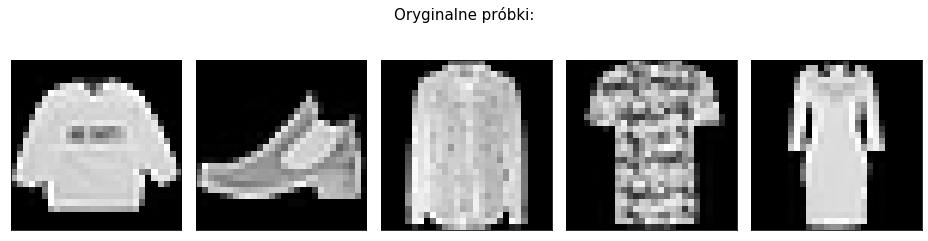

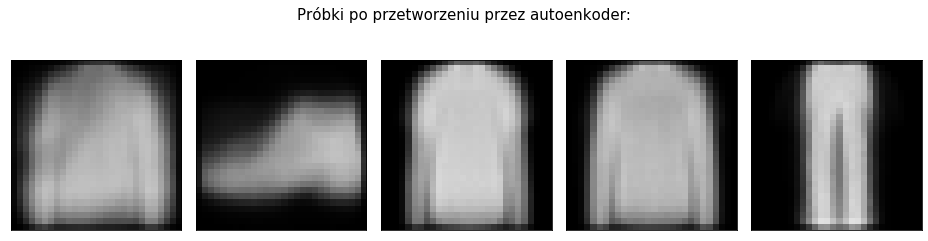

In [98]:
decoded = end_to_end_2hl_d15.predict(train, batch_size=batch_size) * 256.0

print_images(first_5_images, 'Oryginalne próbki:')
print_images(decoded[:5].reshape((5,28,28)), 'Próbki po przetworzeniu przez autoenkoder:')